In [1]:
!pip install torch-summary

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import os
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics import PeakSignalNoiseRatio
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from torch.utils.data import SubsetRandomSampler
from tqdm import tqdm
import time
import wandb
from torchsummary import summary

## Utility Functions

In [4]:
def forward_spc(x: torch.Tensor, H: torch.Tensor) -> torch.Tensor:
    r"""

    Forward propagation through the Single Pixel Camera (SPC) model.

    For more information refer to: Optimized Sensing Matrix for Single Pixel Multi-Resolution Compressive Spectral Imaging 10.1109/TIP.2020.2971150

    Args:
        x (torch.Tensor): Input image tensor of size (B, L, M, N).
        H (torch.Tensor): Measurement matrix of size (S, M*N).

    Returns:
        torch.Tensor: Output measurement tensor of size (B, S, L).
    """
    B, L, M, N = x.size()
    x = x.contiguous().view(B, L, M * N)
    x = x.permute(0, 2, 1)

    # measurement
    H = H.unsqueeze(0).repeat(B, 1, 1)
    y = torch.bmm(H, x)
    return y


def backward_spc(y: torch.Tensor, H: torch.Tensor, pinv= False) -> torch.Tensor:
    r"""

    Inverse operation to reconstruct the image from measurements.

    For more information refer to: Optimized Sensing Matrix for Single Pixel Multi-Resolution Compressive Spectral Imaging  10.1109/TIP.2020.2971150

    Args:
        y (torch.Tensor): Measurement tensor of size (B, S, L).
        H (torch.Tensor): Measurement matrix of size (S, M*N).
        pinv (bool): Boolean, if True the pseudo-inverse of H is used, otherwise the transpose of H is used, defaults to False.
    Returns:
        torch.Tensor: Reconstructed image tensor of size (B, L, M, N).
    """

    Hinv   = torch.pinverse(H) if pinv else torch.transpose(H, 0, 1)
    Hinv   = Hinv.unsqueeze(0).repeat(y.shape[0], 1, 1)

    x = torch.bmm(Hinv, y)
    x = x.permute(0, 2, 1)
    b, c, hw = x.size()
    h = int(np.sqrt(hw))
    x = x.reshape(b, c, h, h)
    x = x/x.max() # normalizetion step to avoid numerical issues
    return x

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False, divisor:int=4):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64//divisor))
        self.down1 = (Down(64//divisor, 128//divisor))
        self.down2 = (Down(128//divisor, 256//divisor))
        self.down3 = (Down(256//divisor, 512//divisor))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512//divisor, 1024//divisor))
        self.up1 = (Up(1024//divisor, 512//divisor, bilinear))
        self.up2 = (Up(512//divisor, 256//divisor, bilinear))
        self.up3 = (Up(256//divisor, 128//divisor, bilinear))
        self.up4 = (Up(128//divisor, 64//divisor, bilinear))
        self.outc = (OutConv(64//divisor, n_channels))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
model = UNet(n_channels=1,divisor=4)
summary(model, (1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 16, 32, 32]          --
|    └─Sequential: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          144
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-3                    [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-6                    [-1, 16, 32, 32]          --
├─Down: 1-2                              [-1, 32, 16, 16]          --
|    └─Sequential: 2-2                   [-1, 32, 16, 16]          --
|    |    └─MaxPool2d: 3-7               [-1, 16, 16, 16]          --
|    |    └─DoubleConv: 3-8              [-1, 32, 16, 16]          13,952
├─Down: 1-3                              [-1, 64, 8, 8]            --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 16, 32, 32]          --
|    └─Sequential: 2-1                   [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 16, 32, 32]          144
|    |    └─BatchNorm2d: 3-2             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-3                    [-1, 16, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 16, 32, 32]          2,304
|    |    └─BatchNorm2d: 3-5             [-1, 16, 32, 32]          32
|    |    └─ReLU: 3-6                    [-1, 16, 32, 32]          --
├─Down: 1-2                              [-1, 32, 16, 16]          --
|    └─Sequential: 2-2                   [-1, 32, 16, 16]          --
|    |    └─MaxPool2d: 3-7               [-1, 16, 16, 16]          --
|    |    └─DoubleConv: 3-8              [-1, 32, 16, 16]          13,952
├─Down: 1-3                              [-1, 64, 8, 8]            --
|    └─

In [7]:
class SPC(nn.Module):
    def __init__(self, pinv:bool = False, num_measurements:int=100, img_size:tuple=(32,32), trainable:bool=True):
        super(SPC, self).__init__()
        self.pinv = pinv
        M, N = img_size
        H = torch.randn(num_measurements, M*N)
        self.H = nn.Parameter(H, requires_grad=trainable)

    def forward(self, x: torch.Tensor) -> torch:
        y = forward_spc(x, self.H)
        x_hat = backward_spc(y, self.H, self.pinv)
        return x_hat

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        return forward_spc(x, self.H)

    def backward_pass(self, y: torch.Tensor) -> torch.Tensor:
        return backward_spc(y, self.H, self.pinv)

In [8]:
class E2E(nn.Module):
    def __init__(self, pinv:bool=False, num_measurements:int=100, img_size:tuple=(32,32), trainable:bool=True, num_channels:int=1):
        super(E2E, self).__init__()
        self.spc = SPC(pinv, num_measurements, img_size, trainable)
        self.unet = UNet(num_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_hat = self.spc(x)
        x_hat = self.unet(x_hat)
        return x_hat

## Load data MNIST dataset

In [9]:
def set_seed(seed: int):
    # os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # torch.use_deterministic_algorithms(mode=True)

In [10]:
def get_validation_set(dst_train, split: float = 0.1, seed: int = 42):

    set_seed(seed)

    indices = list(range(len(dst_train)))
    np.random.shuffle(indices)
    split = int(np.floor(split * len(dst_train)))
    train_indices, val_indices = indices[split:], indices[:split]
    print(len(train_indices), len(val_indices))
    train_sample = SubsetRandomSampler(train_indices)
    val_sample = SubsetRandomSampler(val_indices)

    return train_sample, val_sample

In [11]:
def get_test_val_set(dst_train, split_test=0.1, split_val=0.1, seed: int = 42):

    set_seed(seed)

    indices = list(range(len(dst_train)))
    np.random.shuffle(indices)
    split_test = int(np.floor(split_test * len(dst_train)))
    split_val = int(np.floor(split_val * len(dst_train)))
    train_indices, val_indices, test_indices = (
        indices[split_test + split_val :],
        indices[:split_val],
        indices[split_val : split_test + split_val],
    )
    train_sample = SubsetRandomSampler(train_indices)
    val_sample = SubsetRandomSampler(val_indices)
    test_sample = SubsetRandomSampler(test_indices)
    return train_sample, val_sample, test_sample


def get_dataset(dataset: str, data_path: str, batch_size: int, seed: int = 42):

    set_seed(seed)

    if dataset == "MNIST":
        channel = 1
        im_size = (32, 32)
        num_classes = 10
        transform = transforms.Compose([transforms.Resize(im_size), transforms.ToTensor()])
        dst_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
        dst_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
        train_sample, val_sample = get_validation_set(dst_train, split=0.1, seed=seed)
        class_names = [str(c) for c in range(num_classes)]

    elif dataset == "FMNIST":
        channel = 1
        im_size = (32, 32)
        num_classes = 10
        transform = transforms.Compose([transforms.Resize(im_size), transforms.ToTensor()])
        dst_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
        dst_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)
        train_sample, val_sample = get_validation_set(dst_train, split=0.1, seed=seed)
        class_names = dst_train.classes

    elif dataset == "STL10":
        channel = 1
        im_size = (96, 96)
        num_classes = None
        class_names = None
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Grayscale(num_output_channels=channel)]
        )
        dst_train = datasets.STL10(
            data_path, split="unlabeled", download=True, folds=None, transform=transform
        )
        dst_test = None
        train_sample, val_sample, test_sample = get_test_val_set(
            dst_train, split_test=0.1, split_val=0.1, seed=seed
        )

    else:
        raise ValueError("unknown dataset: %s" % dataset)

    if dataset != "STL10":
        trainloader = torch.utils.data.DataLoader(
            dst_train, batch_size=batch_size, num_workers=0, sampler=train_sample
        )
        valoader = torch.utils.data.DataLoader(
            dst_train, batch_size=batch_size, num_workers=0, sampler=val_sample
        )
        testloader = torch.utils.data.DataLoader(
            dst_test, batch_size=batch_size, shuffle=False, num_workers=0
        )

    elif dataset == "STL10":
        trainloader = torch.utils.data.DataLoader(
            dst_train, batch_size=batch_size, num_workers=0, sampler=train_sample
        )
        valoader = torch.utils.data.DataLoader(
            dst_train, batch_size=batch_size, num_workers=0, sampler=val_sample
        )
        testloader = torch.utils.data.DataLoader(
            dst_train, batch_size=batch_size, num_workers=0, sampler=test_sample
        )

    return (
        channel,
        im_size,
        num_classes,
        class_names,
        dst_train,
        dst_test,
        testloader,
        trainloader,
        valoader,
    )

In [12]:
batch_size = 128
channel,im_size,num_classes,class_names,x_train,x_test,testloader,trainloader,valoader,=get_dataset('MNIST',"data",batch_size)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 346kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

54000 6000


In [13]:
x_train = x_train.data
x_test = x_test.data
x_train.shape, x_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [14]:
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)

print(x_train.shape)
print(x_test.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


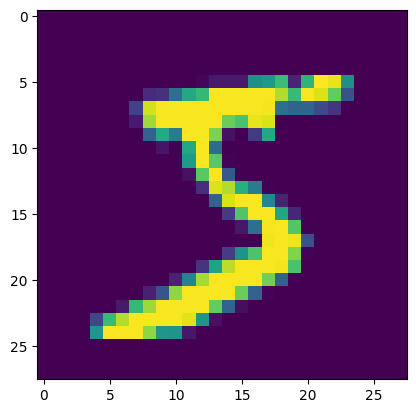

In [15]:
plt.imshow(x_train[0][0].squeeze())

# **Training the model**


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = E2E(pinv=False, num_measurements=122, img_size=(32, 32), trainable=True, num_channels=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [17]:
wandb.login(key="cd514a4398a98306cdedf0ffb4ed08532e9734e5")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: josebarr (josebarr20) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
Epoch: 10/500: 100%|██████████| 47/47 [00:01<00:00, 25.57it/s, loss=tensor(0.0049, device='cuda:0'), psnr=tensor(23.0796, device='cuda:0'), ssim=tensor(0.7522, device='cuda:0')]


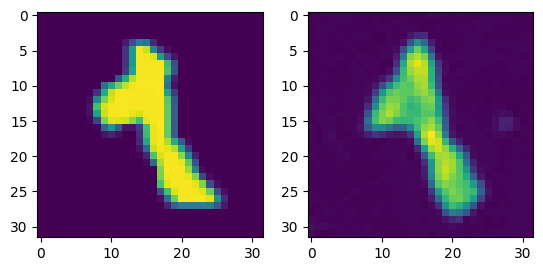

Epoch: 20/500: 100%|██████████| 47/47 [00:02<00:00, 21.50it/s, loss=tensor(0.0039, device='cuda:0'), psnr=tensor(24.1204, device='cuda:0'), ssim=tensor(0.9322, device='cuda:0')]


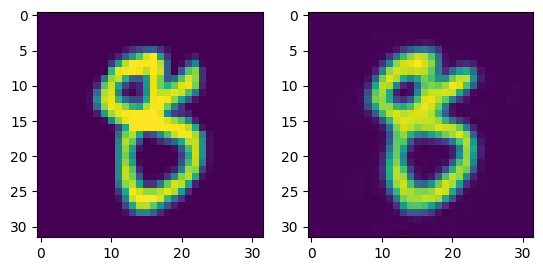

Epoch: 30/500: 100%|██████████| 47/47 [00:01<00:00, 25.40it/s, loss=tensor(0.0033, device='cuda:0'), psnr=tensor(24.8090, device='cuda:0'), ssim=tensor(0.9471, device='cuda:0')]


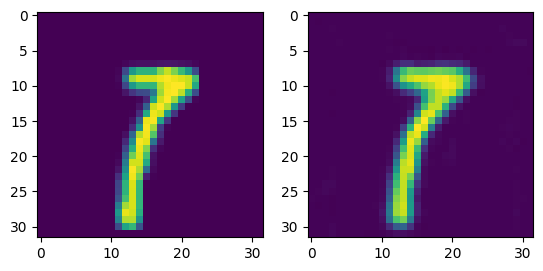

Epoch: 40/500: 100%|██████████| 47/47 [00:01<00:00, 25.37it/s, loss=tensor(0.0066, device='cuda:0'), psnr=tensor(21.8069, device='cuda:0'), ssim=tensor(0.6882, device='cuda:0')]


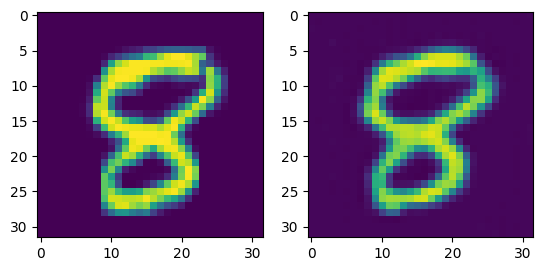

Epoch: 50/500: 100%|██████████| 47/47 [00:02<00:00, 23.49it/s, loss=tensor(0.0029, device='cuda:0'), psnr=tensor(25.3732, device='cuda:0'), ssim=tensor(0.9577, device='cuda:0')]


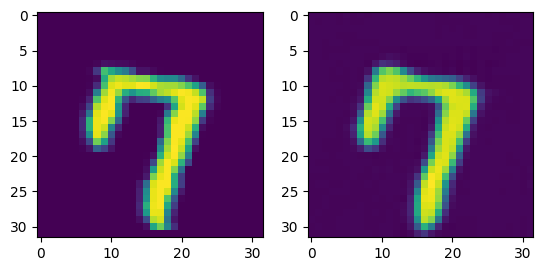

Epoch: 60/500: 100%|██████████| 47/47 [00:01<00:00, 25.70it/s, loss=tensor(0.0030, device='cuda:0'), psnr=tensor(25.2923, device='cuda:0'), ssim=tensor(0.9578, device='cuda:0')]


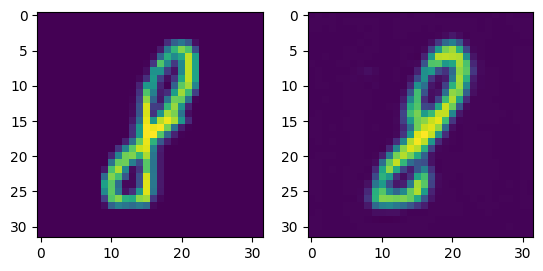

Epoch: 70/500: 100%|██████████| 47/47 [00:01<00:00, 24.30it/s, loss=tensor(0.0028, device='cuda:0'), psnr=tensor(25.5531, device='cuda:0'), ssim=tensor(0.9467, device='cuda:0')]


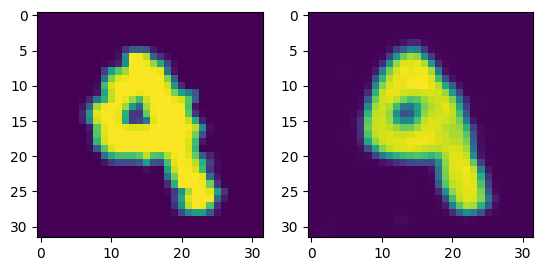

Epoch: 80/500: 100%|██████████| 47/47 [00:02<00:00, 22.55it/s, loss=tensor(0.0046, device='cuda:0'), psnr=tensor(23.3855, device='cuda:0'), ssim=tensor(0.8569, device='cuda:0')]


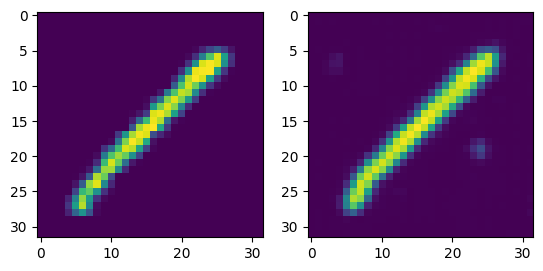

Epoch: 90/500: 100%|██████████| 47/47 [00:01<00:00, 24.45it/s, loss=tensor(0.0026, device='cuda:0'), psnr=tensor(25.8263, device='cuda:0'), ssim=tensor(0.9632, device='cuda:0')]


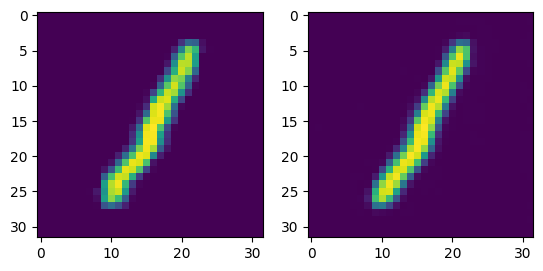

Epoch: 100/500: 100%|██████████| 47/47 [00:01<00:00, 24.38it/s, loss=tensor(0.0041, device='cuda:0'), psnr=tensor(23.8282, device='cuda:0'), ssim=tensor(0.9496, device='cuda:0')]


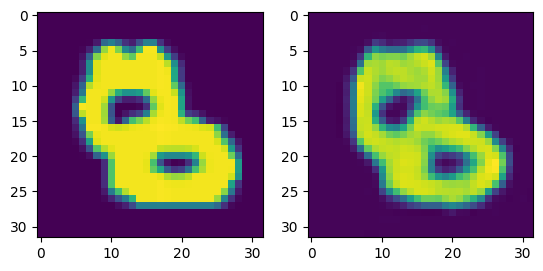

Epoch: 110/500: 100%|██████████| 47/47 [00:02<00:00, 21.16it/s, loss=tensor(0.0026, device='cuda:0'), psnr=tensor(25.8404, device='cuda:0'), ssim=tensor(0.9201, device='cuda:0')]


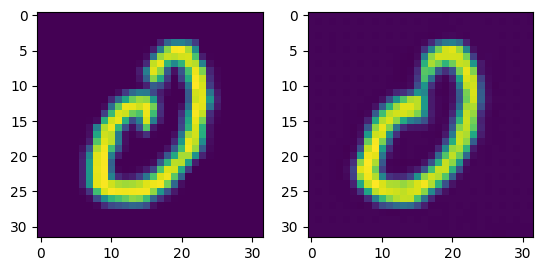

Epoch: 120/500: 100%|██████████| 47/47 [00:01<00:00, 23.85it/s, loss=tensor(0.0027, device='cuda:0'), psnr=tensor(25.6155, device='cuda:0'), ssim=tensor(0.8542, device='cuda:0')]


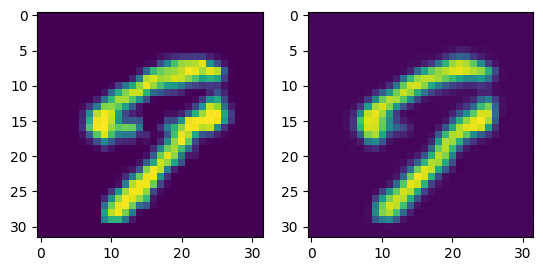

Epoch: 130/500: 100%|██████████| 47/47 [00:01<00:00, 24.07it/s, loss=tensor(0.0029, device='cuda:0'), psnr=tensor(25.4266, device='cuda:0'), ssim=tensor(0.8410, device='cuda:0')]


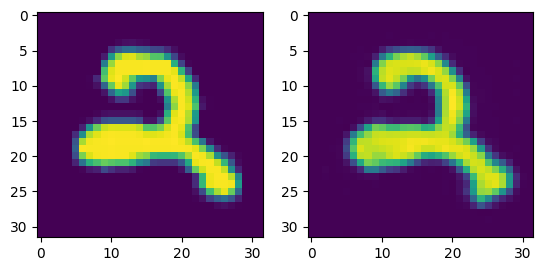

Epoch: 140/500: 100%|██████████| 47/47 [00:02<00:00, 19.52it/s, loss=tensor(0.0025, device='cuda:0'), psnr=tensor(26.0736, device='cuda:0'), ssim=tensor(0.8921, device='cuda:0')]


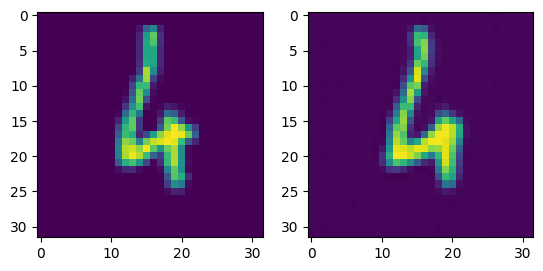

Epoch: 150/500: 100%|██████████| 47/47 [00:01<00:00, 23.72it/s, loss=tensor(0.0031, device='cuda:0'), psnr=tensor(25.1196, device='cuda:0'), ssim=tensor(0.9516, device='cuda:0')]


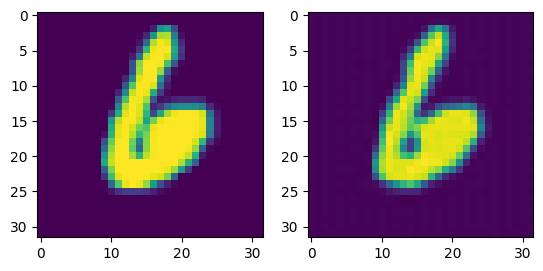

Epoch: 160/500: 100%|██████████| 47/47 [00:01<00:00, 24.17it/s, loss=tensor(0.0029, device='cuda:0'), psnr=tensor(25.3713, device='cuda:0'), ssim=tensor(0.9567, device='cuda:0')]


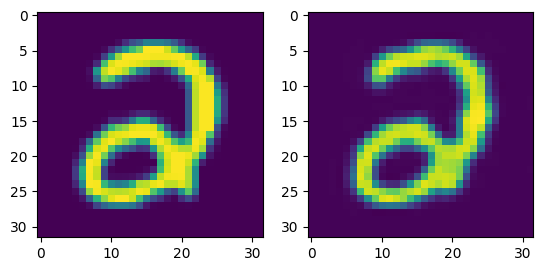

Epoch: 170/500: 100%|██████████| 47/47 [00:02<00:00, 22.80it/s, loss=tensor(0.0024, device='cuda:0'), psnr=tensor(26.1953, device='cuda:0'), ssim=tensor(0.7221, device='cuda:0')]


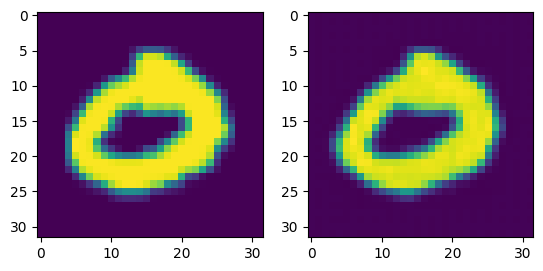

Epoch: 180/500: 100%|██████████| 47/47 [00:02<00:00, 23.32it/s, loss=tensor(0.0022, device='cuda:0'), psnr=tensor(26.5789, device='cuda:0'), ssim=tensor(0.9623, device='cuda:0')]


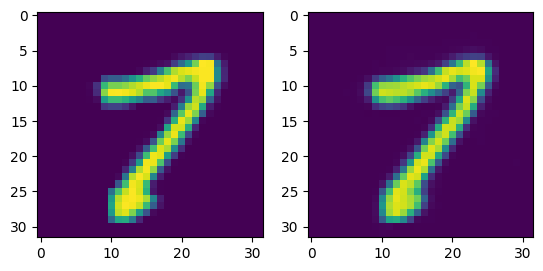

Epoch: 190/500: 100%|██████████| 47/47 [00:02<00:00, 20.36it/s, loss=tensor(0.0024, device='cuda:0'), psnr=tensor(26.1608, device='cuda:0'), ssim=tensor(0.9548, device='cuda:0')]


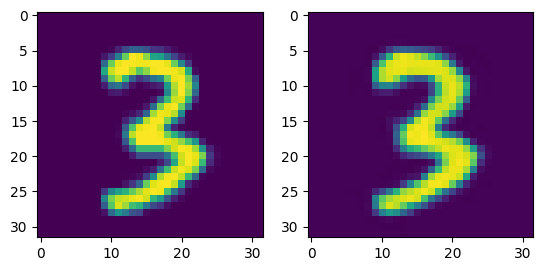

Epoch: 200/500: 100%|██████████| 47/47 [00:02<00:00, 22.83it/s, loss=tensor(0.0021, device='cuda:0'), psnr=tensor(26.8085, device='cuda:0'), ssim=tensor(0.9473, device='cuda:0')]


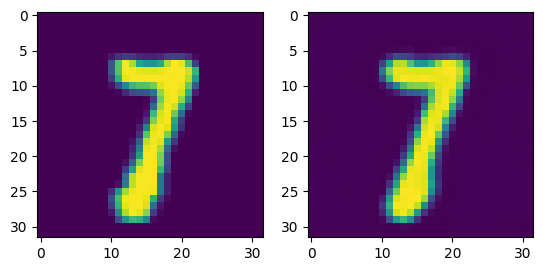

Epoch: 210/500: 100%|██████████| 47/47 [00:02<00:00, 20.77it/s, loss=tensor(0.0041, device='cuda:0'), psnr=tensor(23.8248, device='cuda:0'), ssim=tensor(0.9532, device='cuda:0')]


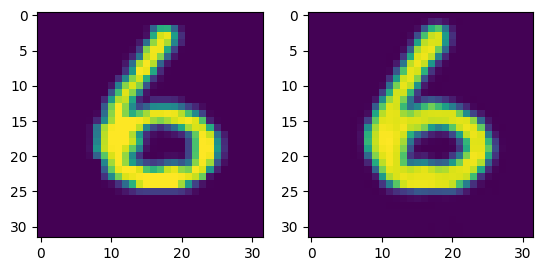

Epoch: 220/500: 100%|██████████| 47/47 [00:02<00:00, 22.81it/s, loss=tensor(0.0022, device='cuda:0'), psnr=tensor(26.6513, device='cuda:0'), ssim=tensor(0.9434, device='cuda:0')]


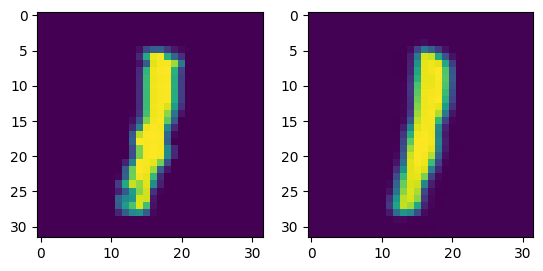

Epoch: 230/500: 100%|██████████| 47/47 [00:02<00:00, 22.53it/s, loss=tensor(0.0067, device='cuda:0'), psnr=tensor(21.7567, device='cuda:0'), ssim=tensor(0.8830, device='cuda:0')]


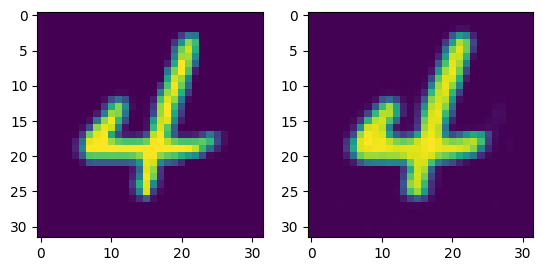

Epoch: 240/500: 100%|██████████| 47/47 [00:02<00:00, 19.47it/s, loss=tensor(0.0030, device='cuda:0'), psnr=tensor(25.1888, device='cuda:0'), ssim=tensor(0.9587, device='cuda:0')]


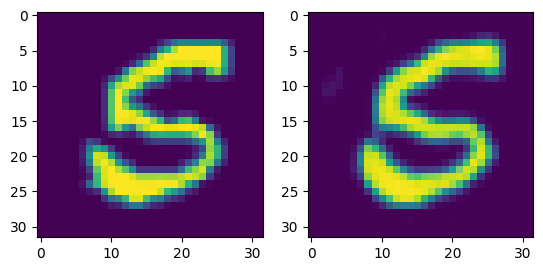

Epoch: 250/500: 100%|██████████| 47/47 [00:02<00:00, 22.47it/s, loss=tensor(0.0038, device='cuda:0'), psnr=tensor(24.1853, device='cuda:0'), ssim=tensor(0.9490, device='cuda:0')]


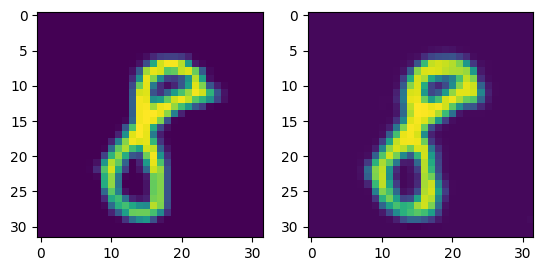

Epoch: 260/500: 100%|██████████| 47/47 [00:02<00:00, 19.11it/s, loss=tensor(0.0019, device='cuda:0'), psnr=tensor(27.3231, device='cuda:0'), ssim=tensor(0.9440, device='cuda:0')]


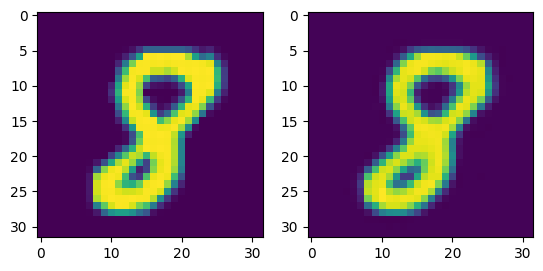

Epoch: 270/500: 100%|██████████| 47/47 [00:02<00:00, 22.35it/s, loss=tensor(0.0022, device='cuda:0'), psnr=tensor(26.6333, device='cuda:0'), ssim=tensor(0.9737, device='cuda:0')]


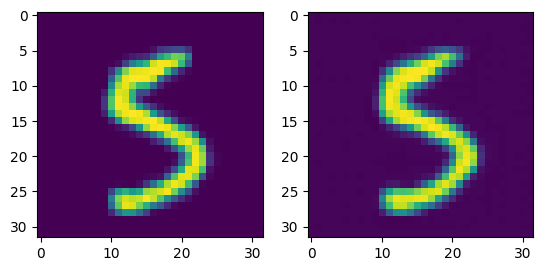

Epoch: 280/500: 100%|██████████| 47/47 [00:02<00:00, 22.47it/s, loss=tensor(0.0022, device='cuda:0'), psnr=tensor(26.6038, device='cuda:0'), ssim=tensor(0.9710, device='cuda:0')]


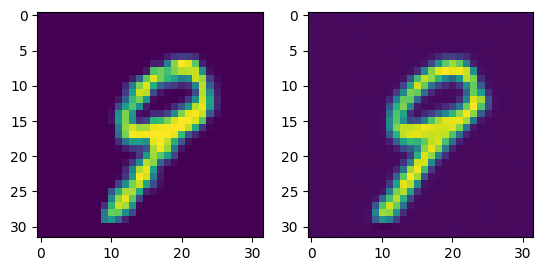

Epoch: 290/500: 100%|██████████| 47/47 [00:02<00:00, 18.30it/s, loss=tensor(0.0023, device='cuda:0'), psnr=tensor(26.4284, device='cuda:0'), ssim=tensor(0.9715, device='cuda:0')]


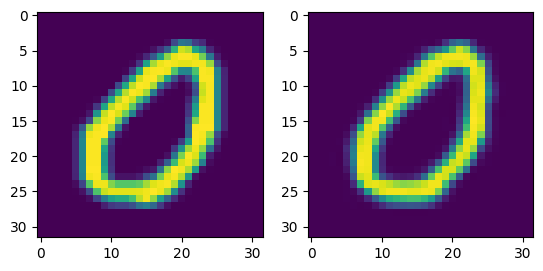

Epoch: 300/500: 100%|██████████| 47/47 [00:02<00:00, 22.05it/s, loss=tensor(0.0023, device='cuda:0'), psnr=tensor(26.3851, device='cuda:0'), ssim=tensor(0.8959, device='cuda:0')]


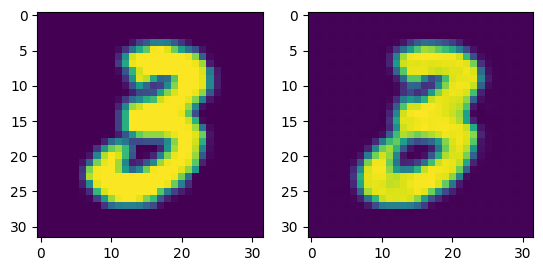

Epoch: 310/500: 100%|██████████| 47/47 [00:02<00:00, 20.10it/s, loss=tensor(0.0023, device='cuda:0'), psnr=tensor(26.3679, device='cuda:0'), ssim=tensor(0.8685, device='cuda:0')]


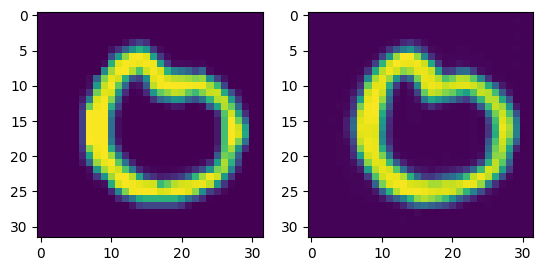

Epoch: 320/500: 100%|██████████| 47/47 [00:02<00:00, 21.71it/s, loss=tensor(0.0021, device='cuda:0'), psnr=tensor(26.7962, device='cuda:0'), ssim=tensor(0.8135, device='cuda:0')]


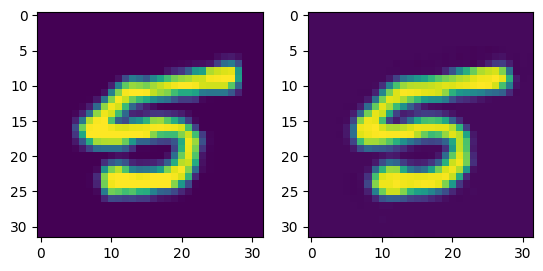

Epoch: 330/500: 100%|██████████| 47/47 [00:02<00:00, 21.84it/s, loss=tensor(0.0019, device='cuda:0'), psnr=tensor(27.2395, device='cuda:0'), ssim=tensor(0.9549, device='cuda:0')]


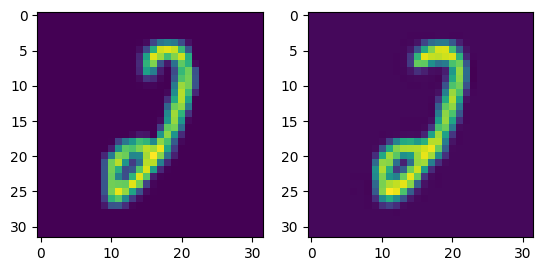

Epoch: 340/500: 100%|██████████| 47/47 [00:02<00:00, 17.82it/s, loss=tensor(0.0023, device='cuda:0'), psnr=tensor(26.4145, device='cuda:0'), ssim=tensor(0.9568, device='cuda:0')]


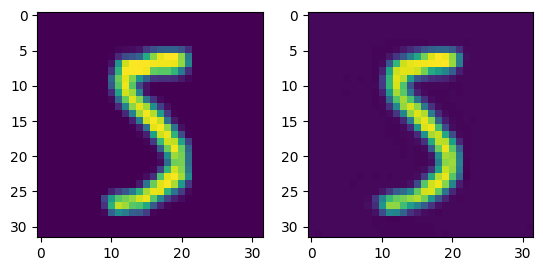

Epoch: 350/500: 100%|██████████| 47/47 [00:02<00:00, 21.53it/s, loss=tensor(0.0022, device='cuda:0'), psnr=tensor(26.5751, device='cuda:0'), ssim=tensor(0.9712, device='cuda:0')]


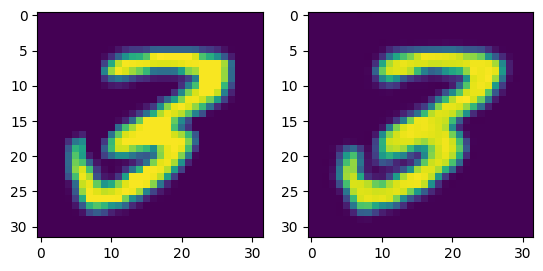

Epoch: 360/500: 100%|██████████| 47/47 [00:02<00:00, 21.14it/s, loss=tensor(0.0018, device='cuda:0'), psnr=tensor(27.3370, device='cuda:0'), ssim=tensor(0.9696, device='cuda:0')]


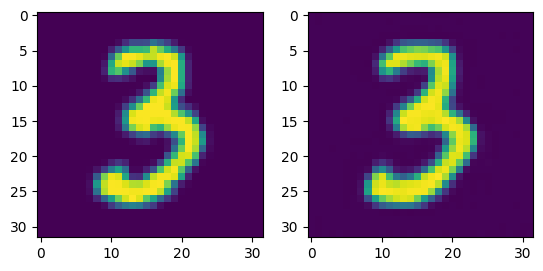

Epoch: 370/500: 100%|██████████| 47/47 [00:02<00:00, 18.22it/s, loss=tensor(0.0023, device='cuda:0'), psnr=tensor(26.4255, device='cuda:0'), ssim=tensor(0.8906, device='cuda:0')]


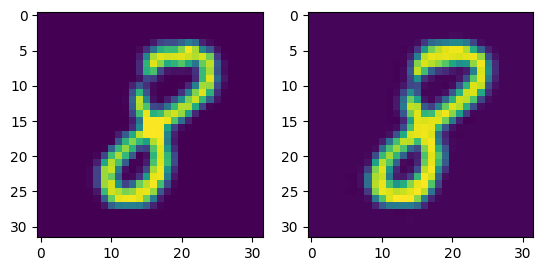

Epoch: 380/500: 100%|██████████| 47/47 [00:02<00:00, 21.43it/s, loss=tensor(0.0029, device='cuda:0'), psnr=tensor(25.3354, device='cuda:0'), ssim=tensor(0.8888, device='cuda:0')]


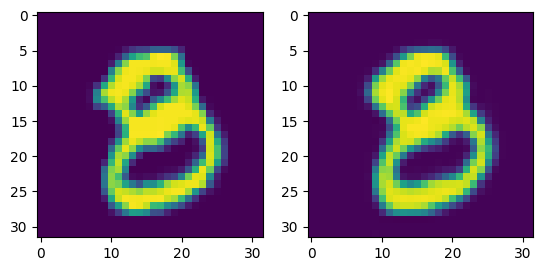

Epoch: 390/500: 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, loss=tensor(0.0027, device='cuda:0'), psnr=tensor(25.6200, device='cuda:0'), ssim=tensor(0.9681, device='cuda:0')]


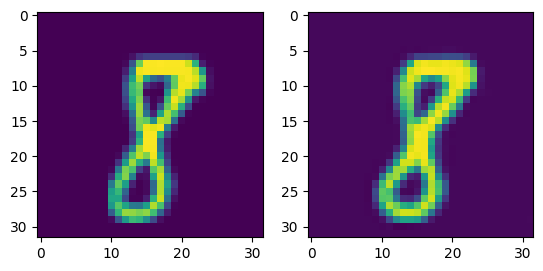

Epoch: 400/500: 100%|██████████| 47/47 [00:02<00:00, 18.73it/s, loss=tensor(0.0018, device='cuda:0'), psnr=tensor(27.5354, device='cuda:0'), ssim=tensor(0.9621, device='cuda:0')]


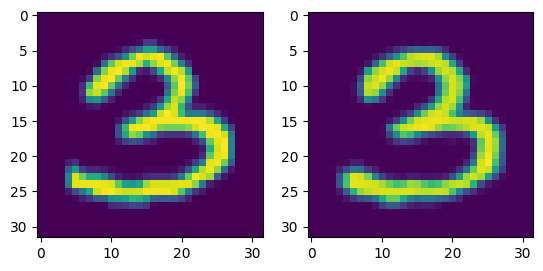

Epoch: 410/500: 100%|██████████| 47/47 [00:02<00:00, 21.57it/s, loss=tensor(0.0023, device='cuda:0'), psnr=tensor(26.2939, device='cuda:0'), ssim=tensor(0.9680, device='cuda:0')]


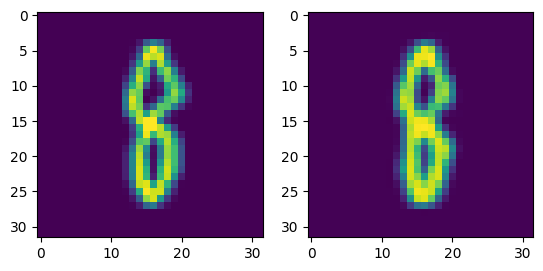

Epoch: 420/500: 100%|██████████| 47/47 [00:02<00:00, 21.53it/s, loss=tensor(0.0019, device='cuda:0'), psnr=tensor(27.1900, device='cuda:0'), ssim=tensor(0.9757, device='cuda:0')]


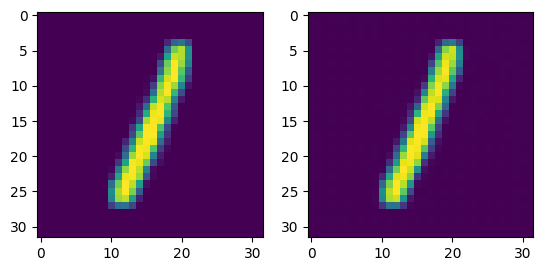

Epoch: 430/500: 100%|██████████| 47/47 [00:02<00:00, 21.11it/s, loss=tensor(0.0020, device='cuda:0'), psnr=tensor(27.0406, device='cuda:0'), ssim=tensor(0.9756, device='cuda:0')]


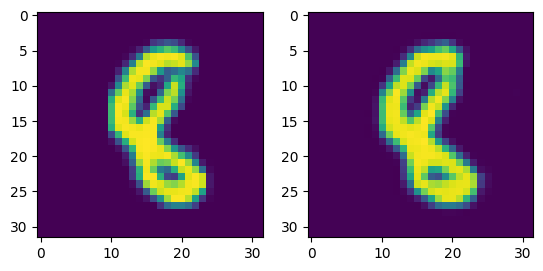

Epoch: 440/500: 100%|██████████| 47/47 [00:02<00:00, 21.52it/s, loss=tensor(0.0019, device='cuda:0'), psnr=tensor(27.2902, device='cuda:0'), ssim=tensor(0.9727, device='cuda:0')]


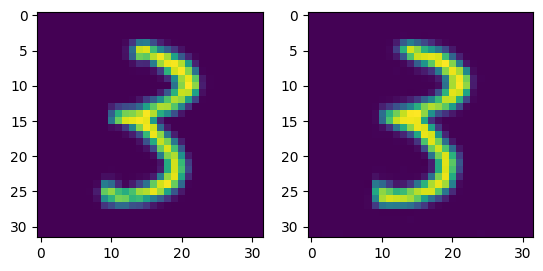

Epoch: 450/500: 100%|██████████| 47/47 [00:02<00:00, 21.57it/s, loss=tensor(0.0021, device='cuda:0'), psnr=tensor(26.8388, device='cuda:0'), ssim=tensor(0.9306, device='cuda:0')]


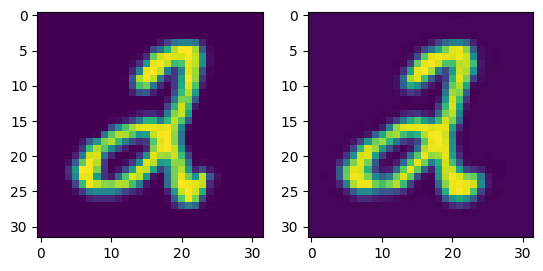

Epoch: 460/500: 100%|██████████| 47/47 [00:02<00:00, 17.92it/s, loss=tensor(0.0025, device='cuda:0'), psnr=tensor(25.9593, device='cuda:0'), ssim=tensor(0.9679, device='cuda:0')]


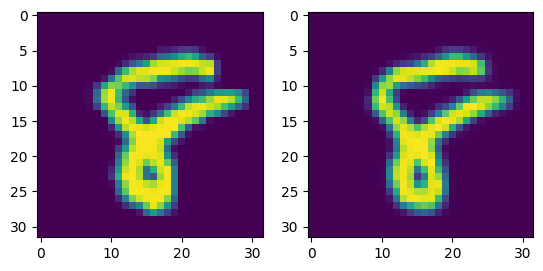

Epoch: 470/500: 100%|██████████| 47/47 [00:02<00:00, 19.08it/s, loss=tensor(0.0021, device='cuda:0'), psnr=tensor(26.8352, device='cuda:0'), ssim=tensor(0.9748, device='cuda:0')]


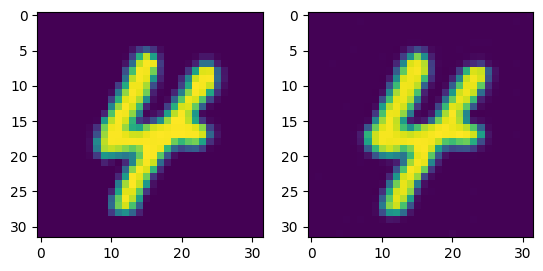

Epoch: 480/500: 100%|██████████| 47/47 [00:02<00:00, 21.79it/s, loss=tensor(0.0018, device='cuda:0'), psnr=tensor(27.4631, device='cuda:0'), ssim=tensor(0.9328, device='cuda:0')]


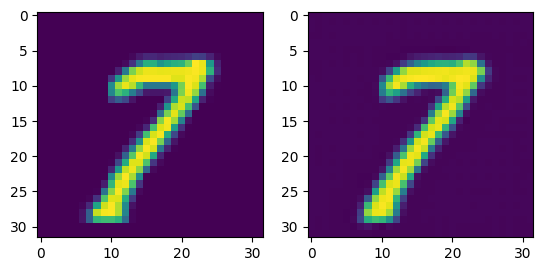

Epoch: 490/500: 100%|██████████| 47/47 [00:02<00:00, 20.16it/s, loss=tensor(0.0021, device='cuda:0'), psnr=tensor(26.8363, device='cuda:0'), ssim=tensor(0.9618, device='cuda:0')]


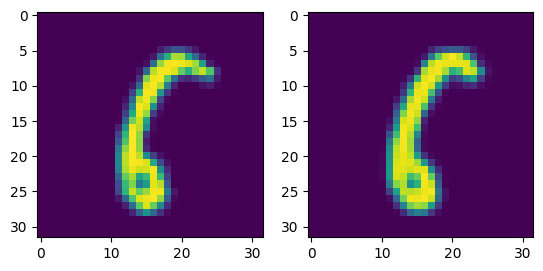

Epoch: 500/500: 100%|██████████| 47/47 [00:02<00:00, 17.95it/s, loss=tensor(0.0019, device='cuda:0'), psnr=tensor(27.2929, device='cuda:0'), ssim=tensor(0.9088, device='cuda:0')]


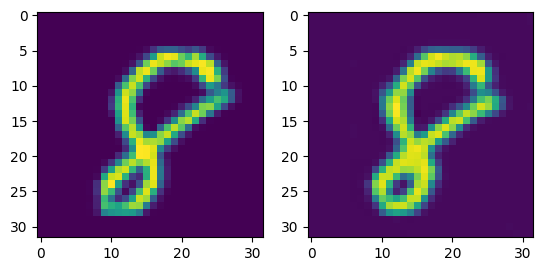

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇█████
train_loss,▅▆█▅▄▄▄▄▃▃▄▃▂▄▅▂▂▂▃▃▂▂▃▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
train_psnr,▁▃▄▄▃▅▅▅▅▆▅▅▆▇▇▅▆▆▇▇▇▆▆▇▇██▇▇▇▆███▇▇███▇
train_ssim,▇▇▆▆█▇▇▇▇▅▇▆▁███▆██▇▇▆▅▆▇▇▇▆█████████▇▇▇
val_loss,▅▄▅▆█▂▂▂▄▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁
val_psnr,▁▃▅▅▂▆▄▅▅▆▇▇▇▆▇▅▇▇▆▇▅▆▅▅▆▇▇█▆█▇█▇▆█▆███▆
val_ssim,▇▆▁▇▇▅▇█▄▇████▁█████▇▆▇▇▅▆▇█▇█▇█▆██▇████
epoch,499
train_loss,0.00036
train_psnr,34.42814
train_ssim,0.96084


In [18]:
num_epochs = 500
wandb.init(name="Prueba Final",project="SPC_E2E_MNIST", config={
    "num_epochs": num_epochs})

ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
# Train stage
model.train()
for epoch in range(num_epochs):
  data_loop_train = tqdm(enumerate(testloader), total=len(testloader), colour="blue")
  for i, (y,_) in data_loop_train:
    y = y.to(device)
    x_hat = model(y).to(device)
    train_loss = criterion(x_hat, y)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    train_ssim = ssim(x_hat, y).to(device)
    train_psnr = psnr(x_hat, y).to(device)
    data_loop_train.set_description(f"Epoch: {epoch+1}/{num_epochs}")
    data_loop_train.set_postfix(loss=train_loss, ssim=train_ssim, psnr=train_psnr)

  # Validation stage
  model.eval()
  with torch.no_grad():
    data_loop_val = tqdm(enumerate(valoader), total=len(valoader), colour="green")
    for i, (y,_) in data_loop_val:
      y = y.to(device)
      x_hat = model(y).to(device)
      val_loss = criterion(x_hat, y).to(device)
      val_ssim = ssim(x_hat, y).to(device)
      val_psnr = psnr(x_hat, y).to(device)
      data_loop_val.set_description(f"Epoch: {epoch+1}/{num_epochs}")
      data_loop_val.set_postfix(loss=val_loss, ssim=val_ssim, psnr=val_psnr)

  if (epoch + 1) % 10 == 0:
    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(y[0].squeeze().squeeze().cpu().detach().numpy())
    aux = x_hat[0].squeeze().squeeze().cpu().detach().numpy()
    axis[1].imshow(aux)
    plt.show()
    wandb_img = wandb.Image(fig)

  wandb.log({"epoch": epoch,
             "train_loss": train_loss.item(),
             "val_loss": val_loss.item(),
             "train_ssim": train_ssim.item(),
             "val_ssim": val_ssim.item(),
             "train_psnr": train_psnr.item(),
             "val_psnr": val_psnr.item(),
             "image": wandb_img if (epoch + 1) % 10 == 0 else None})

wandb.finish()